![PyTorch Logo](images/pytorch1.png)

## Лабораторная работа 2. Семантическая Сегментация.
Выполнил Сомик А.Н.


In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

We will use not only basic functionlaity of `pytorch` but also **`torchvision`** computer vision library.

In [ ]:
!pip freeze | grep torch

# Pytorch as a constructor

## Working with datasets

For data loading pytorch defines **`Dataset`** entity.

This abstract class is defined in `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
One should inherit `Dataset` and implement `__getitem__` and `__len__` nethods to create a new data source.

An example of such ancestor — `torchvision.datasets.ImageFolder`, which allows us to use imagenet-like dataset based on a directory with `./train/{class}` and `./val/{class}` sub-directories structure:

```python
imagenet = torchvision.datasets.ImageFolder("path/to/imagenet_root/")
```

Custom example — a dataset loading images with classes defined in some text file:

In [ ]:
from torch.utils.data import Dataset
# default_loader - default image loading function, uses accimage or PIL
from torchvision.datasets.folder import default_loader

class TxtList(Dataset):
    def __init__(self, path, transform=None, loader=default_loader):
        with open(path) as fin:
            self.imgs = [s.strip().split() for s in fin.readlines()]

        print(f"=> Found {len(self.imgs)} entries in {path}")

        self.classes = sorted(set([_[1] for _ in self.imgs]))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path, target = self.imgs[index]
        target = self.class_to_idx[target]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
!echo /tmp/1.jpg cat > dataset.tsv
!echo /tmp/2.jpg cat >> dataset.tsv
!echo /tmp/3.jpg dog >> dataset.tsv
!echo /tmp/4.jpg cat >> dataset.tsv

In [ ]:
!cat dataset.tsv

In [ ]:
catdog = TxtList("dataset.tsv")

In [ ]:
catdog.classes

In [ ]:
catdog.imgs

In [ ]:
len(catdog)

In [ ]:
# FileNotFoundError
#catdog[0]

`torchvision` has another useful classes for using standard datasets: 
http://pytorch.org/docs/master/torchvision/datasets.html.

Some of them can be preloaded with built-in functionality, for example **MNIST**:

In [ ]:
![ -d "/tmp/mnist/" ] && rm -r "/tmp/mnist/"

In [ ]:
from torchvision.datasets import MNIST

%time mnist = MNIST("/tmp/mnist/", train=True, download=True)

In [ ]:
len(mnist)

In [ ]:
image, target = mnist[0]
print(target)

In [ ]:
plt.imshow(np.array(image), "gray")
plt.show()

## <font color='#cc6666'>Hometask!</font>

Implement **`UrlList`** dataset which costructor takes list of urls as a parameter.

In [ ]:
from typing import List


class UrlList(Dataset):
    def __init__(self, urls: List[str]):
        self._urls = urls
    def __getitem__(self, i):
      return self._urls[i]
    def __len__(self):
      return len(self._urls)


Demonstrate how it works with some examples:

In [ ]:
lst = ["http:google.com", "http:colab", "yandex.com"]
dataset = UrlList(lst)

In [ ]:
dataset[1]

## Data transformation

In the example shown before and in built-in `ImageFolder` `__init__` method has `transform` parameter (and `target_transform`).

They are used to transform images/targets loaded into predefined range and form.

There is `transforms` sub-module in `torchvision` library which has some examples of such transforms:

In [ ]:
from torchvision import transforms

For example `transforms.ToTensor()` transforms uint8 `PIL` [0, 256)-domained images into [0, 1)-domained tensors.

In [ ]:
to_tensor = transforms.ToTensor()

In [ ]:
import numpy as np

In [ ]:
np.asarray(mnist[0][0])

In [ ]:
pil_image = mnist[0][0]
print(pil_image)
th_image = to_tensor(pil_image)
th_image.shape, th_image.min(), th_image.max()

One can define `normalize` to implement a standard ImageNet preparation step:

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

`transforms.Compose` is used to sequence several compositions as a whole:

In [ ]:
crop_and_tensorize = transforms.Compose([
    transforms.CenterCrop(16),
    transforms.ToTensor(),
])

In [ ]:
plt.imshow(crop_and_tensorize(pil_image)[0].numpy(), "gray")
plt.show()

To define a custom transformer we should only implement `__call__` method its implementation:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

It is adviced to take a glance at http://pytorch.org/docs/master/torchvision/transforms.html for standard transformations overview.

## Optional reading

Another example of a good set of pre-defined transformations is [`albumentations`](https://github.com/albu/albumentations) library.

It supports not only image transformations but it can simultaniously transform its corresponding masks and bboxes.

One can also use [`imgaug`](https://github.com/aleju/imgaug) augmentations library but needs to implement `imguag output` -> `tensor` transformations on their own.

## <font color='#cc6666'>Hometask!</font>

Implement a transformer that applies random transformation from $D_4$ transformations group.

These transformations are very usefull for lossless augmentations in satellite images analysis.

In [ ]:
class RandomD4(object):
    def __call__(self, img):
        max_degree = 180
        transform=transforms.RandomAffine(max_degree,translate = list([0.1,0.1]))
        return transform(img)


r = RandomD4()        

Demonstrate how it works on some MNIST images:

In [ ]:
pic = r(pil_image)
plt.imshow(np.array(pic), "gray")
plt.show()

## Data loaders

The main reason to implement `Dataset` class is a magic power of `torchvision` loaders:

In [ ]:
from torch.utils.data import DataLoader

The loaders are built on top of some dataset and allow batch iterating over it.

Those batches in their turn are created with applying the transformations defined in background processes.

Let's look at MNIST dataset with a simple transformer applied as loaders use tensors and not `PIL.Image`s.

In [ ]:
transformed_mnist = MNIST("/tmp/mnist/", train=True, transform=transforms.ToTensor())

In [ ]:
mnist_loader = DataLoader(transformed_mnist, batch_size=16, shuffle=True, num_workers=4)  # shuffle note here

DataLoader standard parameter values are shown above.

One can also add **`pin_memory=True`** to page-lock the memory thus making faster cpu-to-cuda transfer with a non-blocking option.

**`drop_last=True`** is for avoiding batches size skew in the training process.

Let us demonstrate how it works:

In [ ]:
for images, targets in tqdm(mnist_loader):
    pass

There are image batches as tensors on the output:

In [ ]:
images.shape

In [ ]:
targets.shape

The loader instance pre-calculate the total number of batches (what makes `tqdm` happy):

In [ ]:
len(mnist_loader)

Some data example (will be random on each run):

In [ ]:
plt.imshow(images[0][0].numpy(), "gray")
plt.show()

In [ ]:
print(targets[0])

## Building NN models

We should inherit `torch.nn.Module` class to implement pytorch model, `torch.nn` has lots of pre-defined "building bricks".

Their functional analogs are collected in `torch.nn.functional`.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

We have both module and functional versions of max-pooling, activations, upsempling and some other ops:
* `nn.MaxPool2d` / `F.max_pool2d`
* `nn.ReLU` / `F.relu`
* `nn.Upsample(mode='bilinar')` / `F.upsample(mode='bilinar')` — **deprecated**, use `F.interpolate` instead

To compose several nn modules we can use `nn.Sequential`:

In [ ]:
layers = [
    nn.Conv2d(3, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU()
]
unet_down1 = nn.Sequential(*layers)
print(unet_down1)

## Models training

To train a model one must define a looss functions, some of them can also be found in `torch.nn`:

```python
output = model(torch.cat(x, 1))
target = torch.arange(1, 1001)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)
```

We can update the weights manually:

```python
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)
```

Or use built-in optimizer from `torch.optim` family:
```python
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)
```

We need to zero the gradients to disable gradient accumulations that happens by defult (`pytorch` sends its regards to `tf` rnn implementations):
```python
optimizer.zero_grad()
```

After zeroing the gradients we can run both forward and backward stage with loss calculation in-between:
```python
output = net(x)
loss = criterion(output, target)
loss.backward()
```

To update the weights we can use the optimizer again:
```python
optimizer.step()
```

To adjust learning rate in some pre-defined way we can use **`torch.optim.lr_scheduler`** sub-module:
```python
from torch.optim import lr_scheduler
```

To train ResNets on ImageNet with a standard training scheme we can use
```python
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
for epoch in range(100):
    # no scheduler.step() here* 
    # train(...)
    # validate(...)
    scheduler.step()  # == scheduler.step(epoch)
```
\* one **should not** put `scheduler.step()` before `optimizer.step()`, otherwise the first epoch will be "skipped".

## Optional reading

There are several libraries out there like [`pytorch-lightning`](https://github.com/PyTorchLightning/pytorch-lightning), [`kekas`](https://github.com/belskikh/kekas), [`catalyst`](https://github.com/catalyst-team/catalyst) and others that make building pipelines even easier.

# Pytorch in the wild

## Segmentation model creation (with U-Net as an example)

![U-Net scheme](images/unet.png)

In [ ]:
import torch
from torch import nn

Pre-defined heavily-used convolutions:

In [ ]:
def conv3x3(in_channels, out_channels, dilation=1):
    return nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation)

One **encoder block** consists of two sequential convolutions, an activation layer and an optional batch-norm:

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.batch_norm = batch_norm

        self.conv1 = conv3x3(in_channels, out_channels)
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = conv3x3(out_channels, out_channels)
        if self.batch_norm:
            self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.relu2(x)
        return x

In [ ]:
block = EncoderBlock(3, 64)
block

In [ ]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

Alternative definition:

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.block = nn.Sequential()
        self.block.add_module("conv1", conv3x3(in_channels, out_channels))
        if batch_norm:
            self.block.add_module("bn1", nn.BatchNorm2d(out_channels))
        self.block.add_module("relu1", nn.ReLU())
        self.block.add_module("conv2", conv3x3(out_channels, out_channels))
        if batch_norm:
            self.block.add_module("bn2", nn.BatchNorm2d(out_channels))
        self.block.add_module("relu2", nn.ReLU())

    def forward(self, x):
        return self.block(x)

In [ ]:
block = EncoderBlock(3, 64)
block

In [ ]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

And its "functional" version:

In [ ]:
def encoder_block(in_channels, out_channels, batch_norm=False):
    block = nn.Sequential()
    block.add_module("conv1", conv3x3(in_channels, out_channels))
    if batch_norm:
        block.add_module("bn1", nn.BatchNorm2d(out_channels))
    block.add_module("relu1", nn.ReLU())
    block.add_module("conv2", conv3x3(out_channels, out_channels))
    if batch_norm:
        block.add_module("bn2", nn.BatchNorm2d(out_channels))
    block.add_module("relu2", nn.ReLU())
    return block

In [ ]:
block = encoder_block(3, 64)
block

In [ ]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

Encoder is composed from several encoder blocks.

Its final form is defined bu the number of input channels, the number of channels in the first block output and the number of such blocks.

And we need to store preliminary activatons to apply Decoder on.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_filters, num_blocks):
        super().__init__()

        self.num_blocks = num_blocks
        for i in range(num_blocks):
            in_channels = in_channels if not i else num_filters * 2 ** (i - 1)
            out_channels = num_filters * 2 ** i
            self.add_module(f"block{i + 1}", encoder_block(in_channels, out_channels))
            if i != num_blocks - 1:
                self.add_module(f"pool{i + 1}", nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f"block{i + 1}")(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f"pool{i + 1}")(x)
        return acts

Here we can use **`add_module`** way of layers definition as its number is variable.

In [ ]:
encoder = Encoder(in_channels=3, num_filters=8, num_blocks=4)
encoder

In [ ]:
x = torch.zeros(4, 3, 512, 512)

[_.shape for _ in encoder(x)]

Decoder block consists of upscaling "lower" output and concatenating it with a saved encoder block output from the "left".

In [ ]:
Upsample = nn.Upsample

# class Upsample(nn.Module):
#     def __init__(self, scale_factor=2, mode='bilinear'):
#         super().__init__()

#         self.scale_factor = scale_factor
#         self.mode = mode

#     def forward(self, x):
#         return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=True)


class DecoderBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.uppool = Upsample(scale_factor=2, mode="bilinear")
        self.upconv = conv3x3(out_channels * 2, out_channels)
        self.conv1 = conv3x3(out_channels * 2, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)

    def forward(self, down, left):
        x = self.uppool(down)
        x = self.upconv(x)
        x = torch.cat([left, x], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [ ]:
block = DecoderBlock(8)

In [ ]:
y = encoder(x)

In [ ]:
y[1].shape, y[0].shape

In [ ]:
y[2].shape

In [ ]:
block(y[1], y[0]).shape

Let us build Decoder from several decoder blocks:

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f"block{num_blocks - i}", DecoderBlock(num_filters * 2 ** i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f"block{i + 1}")(up, left)
        return up

In [ ]:
decoder = Decoder(8, 3)

In [ ]:
x.shape

In [ ]:
[_.shape for _ in encoder(x)]

In [ ]:
decoder(encoder(x)).shape

In [ ]:
encoder(x)

U-Net is build from Encoder, Decoder and a final classification layer:

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, num_filters=64, num_blocks=4):
        super().__init__()

        print(f"=> Building {num_blocks}-blocks {num_filters}-filter U-Net")

        self.encoder = Encoder(in_channels, num_filters, num_blocks)
        self.decoder = Decoder(num_filters, num_blocks - 1)
        self.final = nn.Conv2d(num_filters, num_classes, 1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

"Integration testing" (pytorch 0.3 legacy code):

In [ ]:
from torch.autograd import Variable

model = UNet(num_classes=1)
if torch.cuda.is_available():
    model.cuda()

images = Variable(torch.randn(4, 3, 416, 416), volatile=True)
if torch.cuda.is_available():
    images = images.cuda()

model.forward(images).shape

```
/home/nizhib/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/home/nizhib/.anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/nizhib/.anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
```

Same for **pytorch 0.4+**:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(num_classes=1)
model.to(device)

images = torch.randn(4, 3, 416, 416).to(device)

with torch.no_grad():
    print(model.forward(images).shape)

We get linear activations as an output.

To train such models we need to use **/.\*WithLogits/** loss functions subset

We can use `torch.sigmoid` or `torch.softmax` to get probabilities (**0.4.1+**, `torch.nn.functional.sigmoid/softmax` before)

## Using pretrained encoder

Encoder blocks structure seen before looks exactly like VGG architecture:

![img](https://www.pyimagesearch.com/wp-content/uploads/2017/03/imagenet_vgg16.png)

Let us have a look at VGG model from `torchvision` library:

In [ ]:
from torchvision.models import vgg13

VGG13 is the VGG version with 2 convolutional layer in each block:

In [ ]:
model = vgg13()

In [ ]:
model

In [ ]:
vgg13(pretrained=False).features

We don't need the classifier, only the features are useful.

They are built from conv-relu-conv-relu + maxpooling.

Let's build encoder blocks via grouping VGG layers:

In [ ]:
class VGG13Encoder(nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()

        backbone = vgg13(pretrained=pretrained).features

        self.num_blocks = num_blocks
        for i in range(self.num_blocks):
            block = nn.Sequential(*[backbone[j] for j in range(i * 5, i * 5 + 4)])
            self.add_module(f"block{i + 1}", block)
            if i != num_blocks - 1:
                self.add_module(f"pool{i + 1}", nn.MaxPool2d(2, 2))
        

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f"block{i + 1}")(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f"pool{i + 1}")(x)
        return acts

In [ ]:
vgg_encoder = VGG13Encoder(num_blocks=4, pretrained=True)
vgg_encoder

Compare it to "vanilla" encoder:

In [ ]:
encoder = Encoder(in_channels=3, num_filters=64, num_blocks=4)
encoder

Both structures are identical!

But now we have some usefull pretrained weights in the decoder.

## <font color='#cc6666'>Hometask!</font>

### Part1. Toy dataset


**Implement** toy dataset to generate noisy ellipses like that:

![img](https://raw.githubusercontent.com/jakeret/tf_unet/master/docs/toy_problem.png)

In [ ]:


 # Create a black image
#mask



The dataset should output both the image and its corresponding mask.

In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import torch
from torch.utils.data import Dataset
from skimage.util import random_noise
from torchvision import transforms


def build_image(circle_amount, picture_size):

  radius_arr = (np.random.choice(range(5,50), size=circle_amount))
  coord_arr = [tuple(np.random.choice(range(picture_size), size=2)) for i in range(circle_amount)]
  mask = np.zeros((picture_size,picture_size), np.uint8)
  mask[:] = 255
  for i in range(circle_amount):
    mask = cv2.circle(mask,(int(coord_arr[i][0]), int(coord_arr[i][1])),int(radius_arr[i]),0,-1)

  #cv2_imshow(mask)

  color_arr = [tuple(np.random.choice(range(256), size=3)) for i in range(circle_amount)]

  img = np.zeros((picture_size,picture_size,3), np.uint8)
  img[:,:,:] = (62,168,132)
  for i in range(circle_amount):
    img = cv2.circle(img,
                    (
                        int(coord_arr[i][0]),
                          int(coord_arr[i][1])),
                    int(radius_arr[i]),
                    (int(color_arr[i][0]),int(color_arr[i][1]),int(color_arr[i][2])),
                    -1)

  noise_img = random_noise(img, mode='s&p',amount=0.05)
  noise_img = np.array(255*noise_img, dtype = 'uint8')
  return transforms.ToTensor()(noise_img), transforms.ToTensor()(mask)




class Ellipses(Dataset):
    def __init__(self, dataset_volume, circle_amount=10, picture_size=512):
      self._dataset_volume = dataset_volume
      self._obj_ar = []
      self._target_ar = []
      self.circle = circle_amount
      self.picture = picture_size

    def __getitem__(self, index):
      token, target = build_image(self.circle,self.picture)
      return token, target.squeeze(0).long()
    def __len__(self):
      return self._dataset_volume








In [ ]:
'''!pip uninstall -y tb-nightly tensorboardX tensorboard
!pip install tensorboard'''
import os
logs_base_dir = "runs_tb"
os.makedirs(logs_base_dir, exist_ok=True)



Define utility function:

**Implement FANet** (https://arxiv.org/abs/2007.03815, if `moy_variant` returns 1 for you) **or BiCANet** (https://arxiv.org/abs/2003.09669, otherwise) based on pretrained **DenseNet** (pytorch) **and DPN** (cadene/pretrainedmodels) networks instead of ResNets from the papers.

It is advised to use `BCEWithLogitsLoss` as a loss function.

In [ ]:
import torch
from torchvision import models
import torch.nn as nn

class resnet50(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet50(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        tail = self.pool(feature4)
        return feature3, feature4, tail
    
class densenet121(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.densenet121(pretrained=pretrained).features
        self.conv0 = self.features.conv0
        self.norm0 = self.features.norm0
        self.relu0 = self.features.relu0
        self.maxpool0 = self.features.pool0
        self.denseblock1 = self.features.denseblock1
        self.transition1 = self.features.transition1
        self.denseblock2 = self.features.denseblock2
        self.transition2 = self.features.transition2
        self.denseblock3 = self.features.denseblock3
        self.transition3 = self.features.transition3
        self.denseblock4 = self.features.denseblock4
        self.norm5 = self.features.norm5
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, input):
        x = self.conv0(input)
        x = self.relu0(self.norm0(x))
        x = self.maxpool0(x)
        x = self.transition1(self.denseblock1(x))
        x = self.transition2(self.denseblock2(x))
        f = self.denseblock3(x) # 1 / 16
        feature3 = self.transition3(f)
        feature4 = self.norm5(self.denseblock4(feature3)) # 1 / 32
        tail = self.pool(feature4)
        return f, feature4, tail

class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2,padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        return self.relu(self.bn(x))

class Spatial_path(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels=3, out_channels=64)
        self.convblock2 = ConvBlock(in_channels=64, out_channels=128)
        self.convblock3 = ConvBlock(in_channels=128, out_channels=256)

    def forward(self, input):
        x = self.convblock1(input)
        x = self.convblock2(x)
        x = self.convblock3(x)
        return x

class AttentionRefinementModule(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.in_channels = in_channels
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input):
        # global average pooling
        x = self.avgpool(input)
        assert self.in_channels == x.size(1), 'in_channels and out_channels should all be {}'.format(x.size(1))
        x = self.conv(x)
        # x = self.sigmoid(self.bn(x))
        x = self.sigmoid(x)
        # channels of input and x should be same
        x = torch.mul(input, x)
        return x


class FeatureFusionModule(torch.nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        # self.in_channels = input_1.channels + input_2.channels
        # resnet50 3328 = 256(from context path) + 1024(from spatial path) + 2048(from spatial path)
        # densenet121  2304 = 256(from context path) + 1024(from spatial path) + 1024(from spatial path)
        self.in_channels = in_channels

        self.convblock = ConvBlock(in_channels=self.in_channels, out_channels=num_classes, stride=1)
        self.conv1 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))


    def forward(self, input_1, input_2):
        x = torch.cat((input_1, input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.convblock(x)
        x = self.avgpool(feature)

        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        x = torch.mul(feature, x)
        x = torch.add(x, feature)
        return x

class BiSeNet(torch.nn.Module):
    def __init__(self, num_classes, context_path='resnet50'):
        super().__init__()
        # build spatial path
        self.saptial_path = Spatial_path()

        if context_path == 'resnet50':
            # build context path
            self.context_path = resnet50()

            # build attention refinement module  for resnet 50
            #if context_path == 'resnet50':
            self.attention_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_module2 = AttentionRefinementModule(2048, 2048)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=2048, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 3328)

        elif context_path == 'densenet121':
            # build context path
            self.context_path = densenet121()
            
            # build attention refinement module for densenet121
            self.attention_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_module2 = AttentionRefinementModule(1024, 1024)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 2304)
        else:
            print('Error: unspport context_path network \n')

        # build final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

   

    def forward(self, input):
        # output of spatial path
        sx = self.saptial_path(input)

        # output of context path
        cx1, cx2, tail = self.context_path(input)
        cx1 = self.attention_module1(cx1)
        cx2 = self.attention_module2(cx2)
        cx2 = torch.mul(cx2, tail)
        # upsampling
        cx1 = torch.nn.functional.interpolate(cx1, size=sx.size()[-2:], mode='bilinear')
        cx2 = torch.nn.functional.interpolate(cx2, size=sx.size()[-2:], mode='bilinear')
        cx = torch.cat((cx1, cx2), dim=1)

        if self.training == True:
            cx1_sup = self.supervision1(cx1)
            cx2_sup = self.supervision2(cx2)
            cx1_sup = torch.nn.functional.interpolate(cx1_sup, size=input.size()[-2:], mode='bilinear')
            cx2_sup = torch.nn.functional.interpolate(cx2_sup, size=input.size()[-2:], mode='bilinear')

        # output of feature fusion module
        result = self.feature_fusion_module(sx, cx)

        # upsampling
        result = torch.nn.functional.interpolate(result, scale_factor=8, mode='bilinear')
        result = self.conv(result)
        result = self.softmax(result)

        if self.training == True:
            cx1_sup = self.softmax(cx1_sup)
            cx2_sup = self.softmax(cx2_sup)
            return result, cx1_sup, cx2_sup
        #result = self.softmax(result)
        return result

**Demonstrate** how they are trained with `tensorboard` screenshots (use torchvision built-in tools).

That includes but not limited to loss curves, masks from different epochs etc.

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import os
from tqdm.notebook import tqdm_notebook

import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score as jsc


def inf(id,net):
  with torch.no_grad():
    net.to('cpu')
    net.eval()
    tok, tar = trainset[id]
    #print(tar)
    #print(tok)
    im_input = torchvision.transforms.ToPILImage()(tok)
    im_mask = torchvision.transforms.ToPILImage()(torch.tensor(tar.unsqueeze(0), dtype = float))
    
    cv2_imshow(np.array(im_input))
    cv2_imshow(np.array(im_mask))

    result = net(tok.unsqueeze(0)).squeeze(0)
    #print(result.squeeze(0).shape)
    pred = torch.argmax(result, dim=0)
    cv2_imshow(np.array(pred))



def nanmean(x):
    """Computes the arithmetic mean ignoring any NaNs."""
    return torch.mean(x[x == x])

EPS = 1e-10

def _fast_hist(true, pred, num_classes):
    mask = (true >= 0) & (true < num_classes)
    k = num_classes * true[mask] + pred[mask]
    #k[k<0] = 0
    hist = torch.bincount(
        k,
        minlength=num_classes ** 2,
    ).reshape(num_classes, num_classes).float()
    return hist

def overall_pixel_accuracy(hist):
    correct = torch.diag(hist).sum()
    total = hist.sum()
    overall_acc = correct / (total + EPS)
    return overall_acc

def eval_metric(targ, pred, num_classes):
    '''
    targ [b, 1, h, w] or [b, h, w]
    pred [b, h, w] (after argmax(dim=1))
    '''
    #num_classes = 2
    hist = torch.zeros((num_classes, num_classes)).to(targ.device)
    for t, p in zip(targ, pred):
        t = t.type(torch.int64)
        p = p.type(torch.int64)
        hist += _fast_hist(t.flatten(), p.flatten(), num_classes)
    overall_acc = overall_pixel_accuracy(hist)
    return overall_acc


def val(num_classes, model, dataloader):
    print('start val!')
    model.eval()
    with torch.no_grad():
        all_accuracy = []
        for data, label in tqdm_notebook(dataloader,disable=False, desc='Validation...'):
            data = data.cuda()
            label = label.cuda()
            pred = model(data)
            accuracy = eval_metric(label, torch.argmax(pred, dim=1), num_classes)
            all_accuracy.append(accuracy)
        all_accuracy = torch.tensor(all_accuracy).to(data.device)
        miou = torch.mean(all_accuracy)
    print('mIoU for validation: %.3f' % float(miou))
    #print("Example:")
    #inf(next(iter(dataloader)),model)

    return float(miou)

def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1,
                      max_iter=100, power=0.9):
	lr = init_lr*(1 - iter/max_iter)**power
	optimizer.param_groups[0]['lr'] = lr
	return lr  
    
def train(model, optimizer, dataloader_train, dataloader_val, n_epoch = 10):
    loss_func = torch.nn.CrossEntropyLoss()
    max_miou = 0
    step = 0
    writer = SummaryWriter('runs_tb')
    for epoch in range(n_epoch):
        print('epoch:', epoch)
        lr = poly_lr_scheduler(optimizer, 0.002, iter=epoch, max_iter=100)
        model.to('cuda')
        model.train()
        loss_record = []
        for  data, label in tqdm_notebook(dataloader_train,disable=False, desc='Training epoch...{}'.format(epoch)):
            data = data.cuda()
            label = label.cuda()
            output, output_sup1, output_sup2 = model(data)
            #print(output.shape,label.shape)
            #print(output)
            loss1 = loss_func(output, label)
            loss2 = loss_func(output_sup1, label)
            loss3 = loss_func(output_sup2, label)
            loss = loss1 + loss2 + loss3
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #lr.step()
            step += 1
            writer.add_scalar('loss_step', loss, step)
            loss_record.append(loss.item())
        loss_train_mean = np.mean(loss_record)
        writer.add_scalar('epoch/loss_epoch_train', float(loss_train_mean), epoch)
        print('loss for train : %f' % (loss_train_mean))
        if epoch % 1 == 0:
            if not os.path.isdir('./checkpoint'):
                os.mkdir('./checkpoint')
            torch.save(model.state_dict(),
                       os.path.join('./checkpoint', (str(epoch)+'-' +'BiSeNet.pth')))

        if epoch % 1 == 0:
            miou = val(2, model, dataloader_val)
            if miou > max_miou:
                max_miou = miou
                torch.save(model.state_dict(),
                           os.path.join('./checkpoint', 'best_model.pth'))
            writer.add_scalar('epoch/miou val', miou, epoch)

In [ ]:
from torch.utils.data import DataLoader
net = BiSeNet(2,context_path='densenet121')
net.to('cuda')
trainset = Ellipses(1000)
valset = Ellipses(200)
train_loader = DataLoader(trainset, batch_size=8, pin_memory  = True)
val_loader = DataLoader(valset, batch_size=16, pin_memory  = True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir {logs_base_dir}

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), 0.002)
train(net, optimizer, train_loader, val_loader,8)

epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



loss for train : 1.321237
start val!



mIoU for validation: 0.984
epoch: 1



loss for train : 1.142843
start val!



mIoU for validation: 0.991
epoch: 2



loss for train : 1.082486
start val!



mIoU for validation: 0.996
epoch: 3



loss for train : 1.060928
start val!



mIoU for validation: 0.998
epoch: 4



loss for train : 1.052669
start val!



mIoU for validation: 0.998
epoch: 5



loss for train : 1.049327
start val!



mIoU for validation: 0.998
epoch: 6



loss for train : 1.048360
start val!



mIoU for validation: 0.998
epoch: 7



loss for train : 1.047733
start val!



mIoU for validation: 0.999


torch.Size([1, 512, 512])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


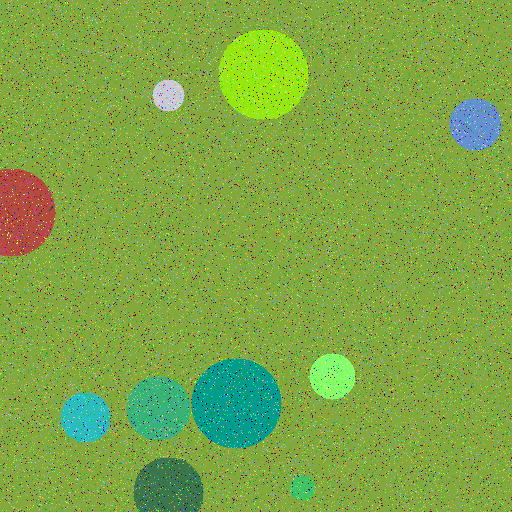

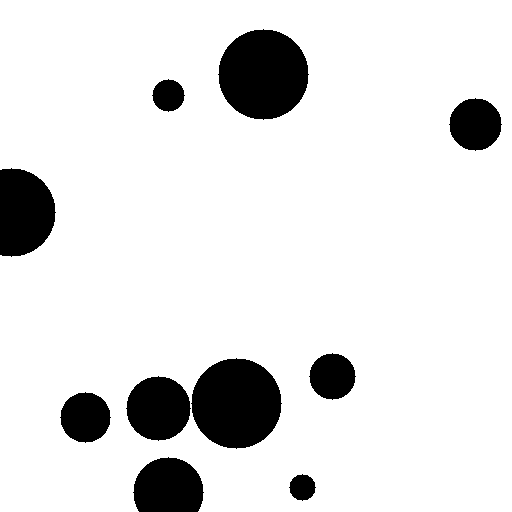

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


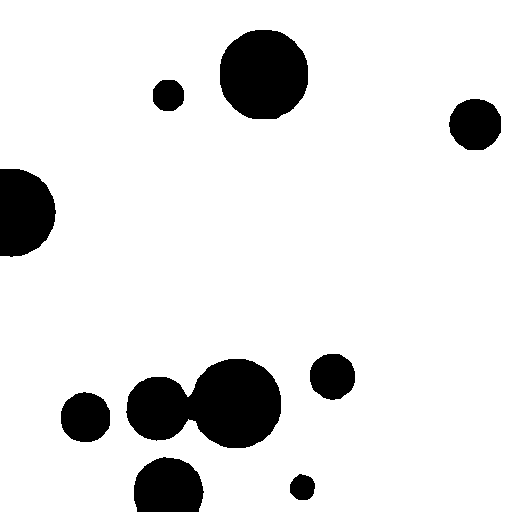

In [ ]:
import torchvision
import matplotlib.pyplot as plt



def inf(net):
  with torch.no_grad():
    net.to('cpu')
    net.eval()
    tok, tar = trainset[0]
    #print(tar)
    #print(tok)
    im_input = torchvision.transforms.ToPILImage()(tok)
    im_mask = torchvision.transforms.ToPILImage()(torch.tensor(tar.unsqueeze(0), dtype = float))
    print(torch.tensor(tar.unsqueeze(0), dtype = float).shape)
    cv2_imshow(np.array(im_input))
    cv2_imshow(np.array(im_mask))
    result = net(tok.unsqueeze(0))
    #print(result)
    ans = torch.argmax(result, dim=1).numpy()
    pred = net(tok.unsqueeze(0))
    pred = torch.argmax(pred, dim=1)
    im_pred = torchvision.transforms.ToPILImage()(torch.tensor(pred, dtype = float))
    #print(im_pred.shape)
    cv2_imshow(np.array(im_pred))

    #fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
    #ax0.imshow(tok.squeeze().permute(1,2,0).cpu().detach().numpy())
    #ax1.imshow(pred.squeeze().cpu().detach().numpy())
    #ax2.imshow(tar.squeeze().cpu().detach().numpy())


    #accuracy = eval_metric(tar, torch.argmax(result, dim=0), 2)
    #print(accuracy)
    #print(ans)
    #
    #pred = torch.argmax(result, dim=1)
    #cv2_imshow((ans))

inf(net)




In [ ]:
'''if not os.path.isdir('./checkpoint'):
            os.mkdir('./checkpoint')
torch.save(net.state_dict(),os.path.join('./checkpoint', ('Best-' +'BiSeNet.pth')))'''

Drive already mounted at /content/Gdrive; to attempt to forcibly remount, call drive.mount("/content/Gdrive", force_remount=True).


### Part 2. Portrait Segmentation

Repeat the training procedures on some real task: http://xiaoyongshen.me/webpage_portrait/.

Easy-to-use dataset version can be downloaded from https://yadi.sk/d/1SSkfLh4WnEhmw.

Use `dice score` as a target scoring function, it should be published in the final report.

All the loss charts, mask quality evolution and final mask examples are expected as well.

In [ ]:
from google.colab import drive

drive.mount('/content/Gdrive')

Mounted at /content/Gdrive


In [ ]:
from PIL import Image
from numpy import asarray
import numpy
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import torch
from torch.utils.data import Dataset
from skimage.util import random_noise
from torchvision import transforms
import os
from os.path import isfile
from os.path import join
from os import listdir


In [ ]:
import torch
from torchvision import models
import torch.nn as nn

class resnet50(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet50(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        tail = self.pool(feature4)
        return feature3, feature4, tail
    
class densenet121(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.densenet121(pretrained=pretrained).features
        self.conv0 = self.features.conv0
        self.norm0 = self.features.norm0
        self.relu0 = self.features.relu0
        self.maxpool0 = self.features.pool0
        self.denseblock1 = self.features.denseblock1
        self.transition1 = self.features.transition1
        self.denseblock2 = self.features.denseblock2
        self.transition2 = self.features.transition2
        self.denseblock3 = self.features.denseblock3
        self.transition3 = self.features.transition3
        self.denseblock4 = self.features.denseblock4
        self.norm5 = self.features.norm5
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, input):
        x = self.conv0(input)
        x = self.relu0(self.norm0(x))
        x = self.maxpool0(x)
        x = self.transition1(self.denseblock1(x))
        x = self.transition2(self.denseblock2(x))
        f = self.denseblock3(x) # 1 / 16
        feature3 = self.transition3(f)
        feature4 = self.norm5(self.denseblock4(feature3)) # 1 / 32
        tail = self.pool(feature4)
        return f, feature4, tail

class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2,padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        return self.relu(self.bn(x))

class Spatial_path(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels=3, out_channels=64)
        self.convblock2 = ConvBlock(in_channels=64, out_channels=128)
        self.convblock3 = ConvBlock(in_channels=128, out_channels=256)

    def forward(self, input):
        x = self.convblock1(input)
        x = self.convblock2(x)
        x = self.convblock3(x)
        return x

class AttentionRefinementModule(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.in_channels = in_channels
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input):
        # global average pooling
        x = self.avgpool(input)
        assert self.in_channels == x.size(1), 'in_channels and out_channels should all be {}'.format(x.size(1))
        x = self.conv(x)
        # x = self.sigmoid(self.bn(x))
        x = self.sigmoid(x)
        # channels of input and x should be same
        x = torch.mul(input, x)
        return x


class FeatureFusionModule(torch.nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        # self.in_channels = input_1.channels + input_2.channels
        # resnet50 3328 = 256(from context path) + 1024(from spatial path) + 2048(from spatial path)
        # densenet121  2304 = 256(from context path) + 1024(from spatial path) + 1024(from spatial path)
        self.in_channels = in_channels

        self.convblock = ConvBlock(in_channels=self.in_channels, out_channels=num_classes, stride=1)
        self.conv1 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))


    def forward(self, input_1, input_2):
        x = torch.cat((input_1, input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.convblock(x)
        x = self.avgpool(feature)

        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        x = torch.mul(feature, x)
        x = torch.add(x, feature)
        return x

class BiSeNet(torch.nn.Module):
    def __init__(self, num_classes, context_path='resnet50'):
        super().__init__()
        # build spatial path
        self.saptial_path = Spatial_path()

        if context_path == 'resnet50':
            # build context path
            self.context_path = resnet50()

            # build attention refinement module  for resnet 50
            #if context_path == 'resnet50':
            self.attention_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_module2 = AttentionRefinementModule(2048, 2048)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=2048, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 3328)

        elif context_path == 'densenet121':
            # build context path
            self.context_path = densenet121()
            
            # build attention refinement module for densenet121
            self.attention_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_module2 = AttentionRefinementModule(1024, 1024)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 2304)
        else:
            print('Error: unspport context_path network \n')

        # build final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

   

    def forward(self, input):
        # output of spatial path
        sx = self.saptial_path(input)

        # output of context path
        cx1, cx2, tail = self.context_path(input)
        cx1 = self.attention_module1(cx1)
        cx2 = self.attention_module2(cx2)
        cx2 = torch.mul(cx2, tail)
        # upsampling
        cx1 = torch.nn.functional.interpolate(cx1, size=sx.size()[-2:], mode='bilinear')
        cx2 = torch.nn.functional.interpolate(cx2, size=sx.size()[-2:], mode='bilinear')
        cx = torch.cat((cx1, cx2), dim=1)

        if self.training == True:
            cx1_sup = self.supervision1(cx1)
            cx2_sup = self.supervision2(cx2)
            cx1_sup = torch.nn.functional.interpolate(cx1_sup, size=input.size()[-2:], mode='bilinear')
            cx2_sup = torch.nn.functional.interpolate(cx2_sup, size=input.size()[-2:], mode='bilinear')

        # output of feature fusion module
        result = self.feature_fusion_module(sx, cx)

        # upsampling
        result = torch.nn.functional.interpolate(result, scale_factor=8, mode='bilinear')
        result = self.conv(result)
        result = self.softmax(result)

        if self.training == True:
            cx1_sup = self.softmax(cx1_sup)
            cx2_sup = self.softmax(cx2_sup)
            return result, cx1_sup, cx2_sup
        #result = self.softmax(result)
        return result

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import os
from tqdm.notebook import tqdm_notebook

import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score as jsc


def inf(id,net):
  with torch.no_grad():
    net.to('cpu')
    net.eval()
    tok, tar = trainset[id]
    #print(tar)
    #print(tok)
    im_input = torchvision.transforms.ToPILImage()(tok)
    im_mask = torchvision.transforms.ToPILImage()(torch.tensor(tar.unsqueeze(0), dtype = float))
    
    cv2_imshow(np.array(im_input))
    cv2_imshow(np.array(im_mask))

    result = net(tok.unsqueeze(0)).squeeze(0)
    #print(result.squeeze(0).shape)
    pred = torch.argmax(result, dim=0)
    cv2_imshow(np.array(pred))



def nanmean(x):
    """Computes the arithmetic mean ignoring any NaNs."""
    return torch.mean(x[x == x])

EPS = 1e-10

def _fast_hist(true, pred, num_classes):
    mask = (true >= 0) & (true < num_classes)
    k = num_classes * true[mask] + pred[mask]
    #k[k<0] = 0
    hist = torch.bincount(
        k,
        minlength=num_classes ** 2,
    ).reshape(num_classes, num_classes).float()
    return hist

def overall_pixel_accuracy(hist):
    correct = torch.diag(hist).sum()
    total = hist.sum()
    overall_acc = correct / (total + EPS)
    return overall_acc

def eval_metric(targ, pred, num_classes):
    '''
    targ [b, 1, h, w] or [b, h, w]
    pred [b, h, w] (after argmax(dim=1))
    '''
    #num_classes = 2
    hist = torch.zeros((num_classes, num_classes)).to(targ.device)
    for t, p in zip(targ, pred):
        t = t.type(torch.int64)
        p = p.type(torch.int64)
        hist += _fast_hist(t.flatten(), p.flatten(), num_classes)
    overall_acc = overall_pixel_accuracy(hist)
    return overall_acc


def val(num_classes, model, dataloader):
    print('start val!')
    model.eval()
    with torch.no_grad():
        all_accuracy = []
        for data, label in tqdm_notebook(dataloader,disable=False, desc='Validation...'):
            data = data.cuda()
            label = label.cuda()
            pred = model(data)
            accuracy = eval_metric(label, torch.argmax(pred, dim=1), num_classes)
            all_accuracy.append(accuracy)
        all_accuracy = torch.tensor(all_accuracy).to(data.device)
        miou = torch.mean(all_accuracy)
    print('mIoU for validation: %.3f' % float(miou))
    #print("Example:")
    #inf(next(iter(dataloader)),model)

    return float(miou)

def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1,
                      max_iter=100, power=0.9):
	lr = init_lr*(1 - iter/max_iter)**power
	optimizer.param_groups[0]['lr'] = lr
	return lr  
    
def train(model, optimizer, dataloader_train, dataloader_val, n_epoch = 10):
    loss_func = torch.nn.CrossEntropyLoss()
    max_miou = 0
    step = 0
    writer = SummaryWriter('runs_tb')
    for epoch in range(n_epoch):
        print('epoch:', epoch)
        lr = poly_lr_scheduler(optimizer, 0.002, iter=epoch, max_iter=100)
        model.to('cuda')
        model.train()
        loss_record = []
        for  data, label in tqdm_notebook(dataloader_train,disable=False, desc='Training epoch...{}'.format(epoch)):
            data = data.cuda()
            label = label.cuda()
            output, output_sup1, output_sup2 = model(data)
            #print(output.shape,label.shape)
            #print(output)
            loss1 = loss_func(output, label)
            loss2 = loss_func(output_sup1, label)
            loss3 = loss_func(output_sup2, label)
            loss = loss1 + loss2 + loss3
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #lr.step()
            step += 1
            writer.add_scalar('loss_step', loss, step)
            loss_record.append(loss.item())
        loss_train_mean = np.mean(loss_record)
        writer.add_scalar('epoch/loss_epoch_train', float(loss_train_mean), epoch)
        print('loss for train : %f' % (loss_train_mean))
        if epoch % 1 == 0:
            if not os.path.isdir('./checkpoint'):
                os.mkdir('./checkpoint')
            torch.save(model.state_dict(),
                       os.path.join('./checkpoint', (str(epoch)+'-' +'BiSeNet.pth')))

        if epoch % 1 == 0:
            miou = val(2, model, dataloader_val)
            if miou > max_miou:
                max_miou = miou
                torch.save(model.state_dict(),
                           os.path.join('./checkpoint', 'best_model.pth'))
            writer.add_scalar('epoch/miou val', miou, epoch)

In [ ]:
def receive_data(path, percentage = 0.8):
  # masks
  #mask_path = path+"/masks"
  onlyfiles_masks = [f for f in listdir(path) if isfile(join(path, f))]

  train_len = int(len(onlyfiles_masks)*percentage)
  test_len = len(onlyfiles_masks) - int(len(onlyfiles_masks)*percentage)
  print("train dnld")
  train_token = [asarray(Image.open(join(path, onlyfiles_masks[i]))) for i in range(train_len)]
  print("test dnld")
  test_token = [asarray(Image.open(join(path, onlyfiles_masks[i]))) for i in range(train_len, len(onlyfiles_masks))]
  return train_token, test_token

In [ ]:
PERCENTAGE = 0.5
train_mask, test_mask = receive_data(path = "/content/Gdrive/My Drive/dataset_segmentation/APSIS.zip (Unzipped Files)/masks",
                                     percentage = PERCENTAGE)
train_token, test_token = receive_data(path = "/content/Gdrive/My Drive/dataset_segmentation/APSIS.zip (Unzipped Files)/images",
                                       percentage = PERCENTAGE)


train dnld
test dnld
train dnld
test dnld


In [ ]:
class Human_DS(Dataset):
    def __init__(self, token, target):
      self._token = token
      self._target = target
      

    def __getitem__(self, index):
      #token, target = build_image(self.circle,self.picture)
      token = self._token[index]
      target = self._target[index]
      return transforms.ToTensor()(token), transforms.ToTensor()(target).squeeze(0).long()
    def __len__(self):
      return len(self._token)

In [ ]:
from torch.utils.data import DataLoader
net = BiSeNet(2,context_path='resnet50')
net.to('cuda')
trainset = Human_DS(train_token,train_mask)
valset = Human_DS(test_token,test_mask)
train_loader = DataLoader(trainset, batch_size=6, pin_memory  = True)
val_loader = DataLoader(valset, batch_size=16, pin_memory  = True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
optimizer = torch.optim.Adam(net.parameters(), 0.002)
train(net, optimizer, train_loader, val_loader,8)

epoch: 0


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



loss for train : 1.737283
start val!



mIoU for validation: 0.384
epoch: 1



loss for train : 1.588760
start val!



mIoU for validation: 0.782
epoch: 2



loss for train : 1.500953
start val!



mIoU for validation: 0.845
epoch: 3



loss for train : 1.418378
start val!



mIoU for validation: 0.837
epoch: 4



loss for train : 1.371672
start val!



mIoU for validation: 0.849
epoch: 5



loss for train : 1.324450
start val!



mIoU for validation: 0.860
epoch: 6



loss for train : 1.297314
start val!



mIoU for validation: 0.843
epoch: 7



loss for train : 1.274612
start val!



mIoU for validation: 0.877


In [ ]:
!/opt/bin/nvidia-smi
#!ps -aux|grep python

Wed Nov 11 19:06:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    48W /  70W |  13743MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
#!kill -9 56

In [ ]:
import torchvision

def inf(net, id, valset):
  with torch.no_grad():
    net.to('cpu')
    net.eval()
    tok, tar = valset[id]
    #print(tar)
    #print(tok)
    im_input = torchvision.transforms.ToPILImage()(tok)
    im_mask = torchvision.transforms.ToPILImage()(torch.tensor(tar.unsqueeze(0), dtype = float))
    print(torch.tensor(tar.unsqueeze(0), dtype = float).shape)
    cv2_imshow(np.array(im_input))
    cv2_imshow(np.array(im_mask))
    result = net(tok.unsqueeze(0))
    #print(result)
    ans = torch.argmax(result, dim=1).numpy()
    pred = net(tok.unsqueeze(0))
    pred = torch.argmax(pred, dim=1)
    im_pred = torchvision.transforms.ToPILImage()(torch.tensor(pred, dtype = float))
    #print(im_pred.shape)
    cv2_imshow(np.array(im_pred))
    img2_fg = cv2.bitwise_and(np.array(im_input),np.array(im_input),mask = np.array(im_pred))
    cv2_imshow(img2_fg)

inf(net,6,valset)

Output hidden; open in https://colab.research.google.com to view.